In [24]:
import cv2
import numpy as np
from skimage import color
import pandas as pd
import matplotlib.pyplot as plt

# Resize video utility

In [25]:
import cv2
import numpy as np


def resize_pad_frame(img, size, pad_color=255, equal_padding=True):
    """
    Resize the frame,
    If image is a horizontal one first match the horizontal axis then resize vertical axis and fill the remaining
    with padding color, similar process for vertical images
    :param equal_padding:
    :param img: frame to be resized
    :param size: final frame size
    :param pad_color: color of tha padding
    :return: re-sized frame
    """
    h, w = float(img.shape[0]), float(img.shape[1])
    expected_height, expected_width = size

    # interpolation method
    if h > expected_height or w > expected_width:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h

    # compute scaling and pad sizing
    if aspect >= 1:  # horizontal image
        new_w = expected_width
        new_h = np.round(new_w / aspect).astype(int)
        if expected_height >= new_h:
            if equal_padding:
                pad_vert = (expected_height - new_h) / 2.0
                pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
                pad_left, pad_right = 0, 0
            else:
                pad_vert = (expected_height - new_h)
                pad_top, pad_bot = 0, pad_vert
                pad_left, pad_right = 0, 0
        else:
            new_h = expected_height
            new_w = np.round(new_h * aspect).astype(int)
            if equal_padding:
                pad_horz = (expected_width - new_w) / 2
                pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
                pad_top, pad_bot = 0, 0
            else:
                pad_horz = (expected_width - new_w)
                pad_left, pad_right = 0, pad_horz
                pad_top, pad_bot = 0, 0

    elif aspect < 1:  # vertical image
        new_h = expected_height
        new_w = np.round(new_h * aspect).astype(int)
        if expected_width >= new_w:
            if equal_padding:
                pad_horz = (expected_width - new_w) / 2
                pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
                pad_top, pad_bot = 0, 0
            else:
                pad_horz = (expected_width - new_w)
                pad_left, pad_right = 0, pad_horz
                pad_top, pad_bot = 0, 0
        else:
            new_w = expected_width
            new_h = np.round(new_w / aspect).astype(int)
            if equal_padding:
                pad_vert = (expected_height - new_h) / 2.0
                pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
                pad_left, pad_right = 0, 0
            else:
                pad_vert = (expected_height - new_h)
                pad_top, pad_bot = 0, pad_vert
                pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(pad_color,
                                              (list, tuple, np.ndarray)):  # color image but only one color provided
        pad_color = [pad_color] * 3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=pad_color)

    return scaled_img


# Get Video

In [26]:
def get_video(file):
    video = cv2.VideoCapture(file)
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frame = resize_pad_frame(frame, (320, 240))
        frames.append(frame)
    frames = np.asarray(frames)
    return frames

# Convert Video

In [27]:
def convert_color(frames, conversion = "rgb2lab"):
    converted_frames = []
    for frame in frames:
        converted_frame = None
        if conversion == "rgb2ycbcr":
            converted_frame = color.rgb2ycbcr(frame)
        else:
            converted_frame = color.rgb2lab(frame)
        converted_frames.append(converted_frame)
    return np.asarray(converted_frames)


# Find STD

In [28]:
def find_stats(video_file):
    frames = get_video(video_file)
    yuv_frames = convert_color(frames, conversion="rgb2ycbcr")
    
    y_frames = yuv_frames[:,:,:,0]
    y_frames_pd = pd.DataFrame(np.transpose(np.reshape(y_frames,(y_frames.shape[0],y_frames.shape[1]*y_frames.shape[2]))))

    u_frames = yuv_frames[:,:,:,1]
    u_frames_pd = pd.DataFrame(np.transpose(np.reshape(u_frames,(u_frames.shape[0],u_frames.shape[1]*u_frames.shape[2]))))

    v_frames = yuv_frames[:,:,:,2]
    v_frames_pd = pd.DataFrame(np.transpose(np.reshape(v_frames,(v_frames.shape[0],v_frames.shape[1]*v_frames.shape[2]))))
    
    y_frames_pd['std'] = y_frames_pd.transpose().std()
    u_frames_pd['std'] = u_frames_pd.transpose().std()
    v_frames_pd['std'] = v_frames_pd.transpose().std()
    y_frames_pd['mean'] = y_frames_pd.transpose().mean()
    u_frames_pd['mean'] = u_frames_pd.transpose().mean()
    v_frames_pd['mean'] = v_frames_pd.transpose().mean()
    
    return [y_frames_pd['std'],u_frames_pd['std'], v_frames_pd['std']]
    

# Mean Squared Error

In [29]:
from sklearn.metrics import mean_squared_error

def evaluate_mse(ground_truth_std, prediction_std):
    answers = []
    assert len(ground_truth_std) == len(prediction_std)
    for i in range(len(ground_truth_std)):
        answers.append(mean_squared_error(ground_truth_std[i],prediction_std[i]))
    return answers

# Pearson Correlation

In [30]:
from scipy.stats import pearsonr
def evaluate_pearson_corr(ground_truth_std, prediction_std):
    answers = []
    assert len(ground_truth_std) == len(prediction_std)
    for i in range(len(ground_truth_std)):
        answers.append(pearsonr(ground_truth_std[i],prediction_std[i])[0])
    return answers

# Execution

In [31]:
ground_truth_stds = find_stats('/home/chamath/flowchroma/test/video_00065.avi')
prediction_stds = find_stats('/home/chamath/flowchroma/test_results/aaaaa.avi')

In [32]:
evaluate_mse(ground_truth_stds, prediction_stds)

[0.290785290104492, 4.148003967958347, 1.8955794519558429]

# Visualization

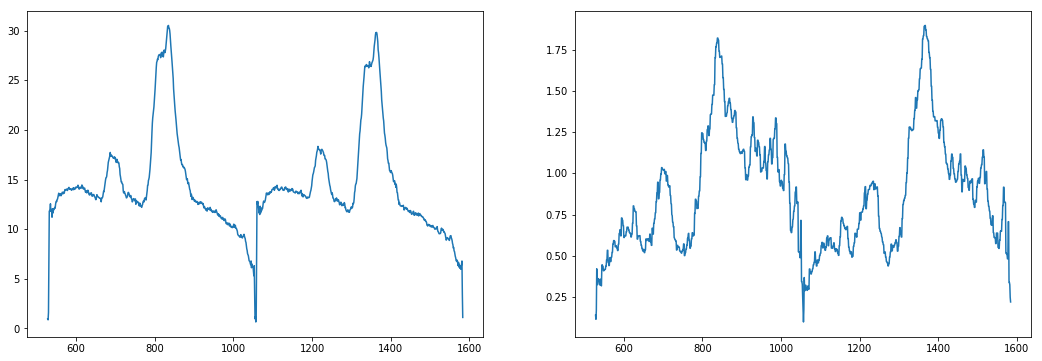

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2)
ground_truth_stds[0][528:3*528].plot.line(ax=ax1,figsize=(18, 6))
ground_truth_stds[1].loc[528:3*528].plot.line(ax=ax2,figsize=(18, 6))
# u_frames_pd['mean'].loc[528:3*528].plot.line(ax=ax2,figsize=(18, 6))
# y_frames_pd['mean'].hist(ax=ax2,figsize=(18, 6))